## Measure of 'Happiness'

In [1]:
import os
import time 
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error,mean_absolute_error, f1_score
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.ensemble import ExtraTreesRegressor as etr
from sklearn.linear_model import BayesianRidge as br
from sklearn.ensemble import GradientBoostingRegressor as gbr
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression as lr
from sklearn.linear_model import ElasticNet as en
from sklearn.kernel_ridge import KernelRidge as kr
from sklearn.model_selection import  KFold, StratifiedKFold,GroupKFold, RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
import logging
import warnings

warnings.filterwarnings('ignore')

### Dataset

In [2]:
train = pd.read_csv("/Users/Melodie/Downloads/2021Spring/Study/DataWhale/April_Ensembled_Learning/Notes_Ensemble_Learning/Data/case_1/train.csv", parse_dates=['survey_time'],encoding='latin-1') 
test = pd.read_csv("/Users/Melodie/Downloads/2021Spring/Study/DataWhale/April_Ensembled_Learning/Notes_Ensemble_Learning/Data/case_1/test.csv", parse_dates=['survey_time'],encoding='latin-1') #latin-1向下兼容ASCII

#Remove the 'happiness' variable
train = train[train["happiness"]!=-8].reset_index(drop=True)
train_data_copy = train.copy() 

#'Happiness' variable
target_col = "happiness" 
target = train_data_copy[target_col]
del train_data_copy[target_col] 

data = pd.concat([train_data_copy,test],axis=0,ignore_index=True)

EDA 'Happiness' variable

In [3]:
train.happiness.describe() 

count    7988.000000
mean        3.867927
std         0.818717
min         1.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: happiness, dtype: float64

In [4]:
data.columns

Index(['id', 'survey_type', 'province', 'city', 'county', 'survey_time',
       'gender', 'birth', 'nationality', 'religion',
       ...
       'neighbor_familiarity', 'public_service_1', 'public_service_2',
       'public_service_3', 'public_service_4', 'public_service_5',
       'public_service_6', 'public_service_7', 'public_service_8',
       'public_service_9'],
      dtype='object', length=139)

## Data Preprocessing

There are some negative values. We wants to figure out how many such negative values in each row.

In [5]:
def getres1(row):
    return len([x for x in row.values if type(x)==int and x<0])

def getres2(row):
    return len([x for x in row.values if type(x)==int and x==-8])

def getres3(row):
    return len([x for x in row.values if type(x)==int and x==-1])

def getres4(row):
    return len([x for x in row.values if type(x)==int and x==-2])

def getres5(row):
    return len([x for x in row.values if type(x)==int and x==-3])

data['neg1'] = data[data.columns].apply(lambda row:getres1(row),axis=1)
data['neg2'] = data[data.columns].apply(lambda row:getres2(row),axis=1)
data['neg3'] = data[data.columns].apply(lambda row:getres3(row),axis=1)
data['neg4'] = data[data.columns].apply(lambda row:getres4(row),axis=1)
data['neg5'] = data[data.columns].apply(lambda row:getres5(row),axis=1)

#When there are more than 20 negative values in one observation, we set it to be 20 (Why?)
data.loc[data['neg1']>20,'neg1'] = 20 

Filling the Missing values

In [6]:


data['work_status'] = data['work_status'].fillna(0)
data['work_yr'] = data['work_yr'].fillna(0)
data['work_manage'] = data['work_manage'].fillna(0)
data['work_type'] = data['work_type'].fillna(0)

data['edu_yr'] = data['edu_yr'].fillna(0)
data['edu_status'] = data['edu_status'].fillna(0)

data['s_work_type'] = data['s_work_type'].fillna(0)
data['s_work_status'] = data['s_work_status'].fillna(0)
data['s_political'] = data['s_political'].fillna(0)
data['s_hukou'] = data['s_hukou'].fillna(0)
data['s_income'] = data['s_income'].fillna(0)
data['s_birth'] = data['s_birth'].fillna(0)
data['s_edu'] = data['s_edu'].fillna(0)
data['s_work_exper'] = data['s_work_exper'].fillna(0)

data['minor_child'] = data['minor_child'].fillna(0)
data['marital_now'] = data['marital_now'].fillna(0)
data['marital_1st'] = data['marital_1st'].fillna(0)
data['social_neighbor']=data['social_neighbor'].fillna(0)
data['social_friend']=data['social_friend'].fillna(0)
data['hukou_loc']=data['hukou_loc'].fillna(1) 
#Use mean to fill
data['family_income']=data['family_income'].fillna(66365)

In [7]:
data['survey_time'] = pd.to_datetime(data['survey_time'], format='%Y-%m-%d',errors='coerce')
data['survey_time'] = data['survey_time'].dt.year
#The age while doing the survey
data['age'] = data['survey_time']-data['birth']

#Categorize the age to be 6 categories: 0-17/18-26/27-34/....
bins = [0,17,26,34,50,63,100]
data['age_bin'] = pd.cut(data['age'], bins, labels=[0,1,2,3,4,5]) 

Note: when dealing with the missing value, here used some subjective standards

In [8]:
data['height_cm'].min()

100

In [9]:
#Religion, if less than 0 - no religion
data.loc[data['religion']<0,'religion'] = 1 
data.loc[data['religion_freq']<0,'religion_freq'] = 1 

#Education level - if less than 0, set to be middle school. (But there are people especially cohort born before 1950, it is likely that their highest education level is primary school)
data.loc[data['edu']<0,'edu'] = 4 #Middle school
data.loc[data['edu_status']<0,'edu_status'] = 0
data.loc[data['edu_yr']<0,'edu_yr'] = 0

#Why there are negative value for income? 'Prefer not to say' or 'no income'?
data.loc[data['income']<0,'income'] = 0 

data.loc[data['political']<0,'political'] = 1 #Default not in the party


data.loc[(data['weight_jin']<=80)&(data['height_cm']>=160),'weight_jin']= data['weight_jin']*2
# data.loc[data['weight_jin']<=60,'weight_jin']= data['weight_jin']*2  #Data integrity

# Minimum value of height_cm is 100, which makes sense
# data.loc[data['height_cm']<150,'height_cm'] = 150 

#Health
data.loc[data['health']<0,'health'] = 3 
data.loc[data['health_problem']<0,'health_problem'] = 3

data.loc[data['depression']<0,'depression'] = 3 

data.loc[data['media_1']<0,'media_1'] = 1 
data.loc[data['media_2']<0,'media_2'] = 1
data.loc[data['media_3']<0,'media_3'] = 1
data.loc[data['media_4']<0,'media_4'] = 1
data.loc[data['media_5']<0,'media_5'] = 1
data.loc[data['media_6']<0,'media_6'] = 1

data.loc[data['leisure_1']<0,'leisure_1'] = 1 
data.loc[data['leisure_2']<0,'leisure_2'] = 5
data.loc[data['leisure_3']<0,'leisure_3'] = 3

Dealing with missing value in categorical data - mode

In [10]:
data.loc[data['leisure_4']<0,'leisure_4'] = data['leisure_4'].mode() 
data.loc[data['leisure_5']<0,'leisure_5'] = data['leisure_5'].mode()
data.loc[data['leisure_6']<0,'leisure_6'] = data['leisure_6'].mode()
data.loc[data['leisure_7']<0,'leisure_7'] = data['leisure_7'].mode()
data.loc[data['leisure_8']<0,'leisure_8'] = data['leisure_8'].mode()
data.loc[data['leisure_9']<0,'leisure_9'] = data['leisure_9'].mode()
data.loc[data['leisure_10']<0,'leisure_10'] = data['leisure_10'].mode()
data.loc[data['leisure_11']<0,'leisure_11'] = data['leisure_11'].mode()
data.loc[data['leisure_12']<0,'leisure_12'] = data['leisure_12'].mode()
data.loc[data['socialize']<0,'socialize'] = data['socialize'].mode()
data.loc[data['relax']<0,'relax'] = data['relax'].mode()
data.loc[data['learn']<0,'learn'] = data['learn'].mode()

data.loc[data['social_neighbor']<0,'social_neighbor'] = 0
data.loc[data['social_friend']<0,'social_friend'] = 0
data.loc[data['socia_outing']<0,'socia_outing'] = 1
data.loc[data['neighbor_familiarity']<0,'neighbor_familiarity']= 4

data.loc[data['equity']<0,'equity'] = 4

data.loc[data['class_10_before']<0,'class_10_before'] = 3
data.loc[data['class']<0,'class'] = 5
data.loc[data['class_10_after']<0,'class_10_after'] = 5
data.loc[data['class_14']<0,'class_14'] = 2

data.loc[data['work_status']<0,'work_status'] = 0
data.loc[data['work_yr']<0,'work_yr'] = 0
data.loc[data['work_manage']<0,'work_manage'] = 0
data.loc[data['work_type']<0,'work_type'] = 0

data.loc[data['insur_1']<0,'insur_1'] = 1
data.loc[data['insur_2']<0,'insur_2'] = 1
data.loc[data['insur_3']<0,'insur_3'] = 1
data.loc[data['insur_4']<0,'insur_4'] = 1
data.loc[data['insur_1']==0,'insur_1'] = 0
data.loc[data['insur_2']==0,'insur_2'] = 0
data.loc[data['insur_3']==0,'insur_3'] = 0
data.loc[data['insur_4']==0,'insur_4'] = 0

Dealing with missing continuous data - mean

In [11]:
data[data['family_income'] >=0]['family_income'].mean()

72464.02361969305

In [12]:
data.loc[data['family_income']<0,'family_income'] = data[data['family_income'] >=0]['family_income'].mean()
data.loc[data['family_m']<0,'family_m'] = 1
data.loc[data['family_status']<0,'family_status'] = data['family_status'].mode()
data.loc[data['house']<0,'house'] = 1
data.loc[data['car']<0,'car'] = 0
data.loc[data['car']==2,'car'] = 0 
data.loc[data['son']<0,'son'] = 0
data.loc[data['daughter']<0,'daughter'] = 0
data.loc[data['minor_child']<0,'minor_child'] = 0

data.loc[data['marital_1st']<0,'marital_1st'] = 0
data.loc[data['marital_now']<0,'marital_now'] = 0

data.loc[data['s_birth']<0,'s_birth'] = 0
data.loc[data['s_edu']<0,'s_edu'] = 0
data.loc[data['s_political']<0,'s_political'] = 0
data.loc[data['s_hukou']<0,'s_hukou'] = 0
data.loc[data['s_income']<0,'s_income'] = 0
data.loc[data['s_work_type']<0,'s_work_type'] = 0
data.loc[data['s_work_status']<0,'s_work_status'] = 0
data.loc[data['s_work_exper']<0,'s_work_exper'] = 0

data.loc[data['f_birth']<0,'f_birth'] = data[data['f_birth'] >=0]['f_birth'].mean()
data.loc[data['f_edu']<0,'f_edu'] = 1
data.loc[data['f_political']<0,'f_political'] = 1
data.loc[data['f_work_14']<0,'f_work_14'] = 2
data.loc[data['m_birth']<0,'m_birth'] = data[data['m_birth'] >=0]['m_birth'].mean()
data.loc[data['m_edu']<0,'m_edu'] = 1
data.loc[data['m_political']<0,'m_political'] = 1
data.loc[data['m_work_14']<0,'m_work_14'] = 2

data.loc[data['status_peer']<0,'status_peer'] = 2

data.loc[data['status_3_before']<0,'status_3_before'] = 2

data.loc[data['view']<0,'view'] = data[data['view'] >=0]['view'].mean()

data.loc[data['inc_ability']<=0,'inc_ability']= data[data['inc_ability'] >=0]['inc_ability'].mean()

data.loc[data['inc_exp']<=0,'inc_exp']= data[data['inc_exp'] >=0]['inc_exp'].mean()

for i in range(1,9+1):
    data.loc[data['public_service_'+str(i)]<0,'public_service_'+str(i)] = data['public_service_'+str(i)].dropna().mode().values
for i in range(1,13+1):
    data.loc[data['trust_'+str(i)]<0,'trust_'+str(i)] = data['trust_'+str(i)].dropna().mode().values

## Data Augmentation

In [13]:

data['marital_1stbir'] = data['marital_1st'] - data['birth'] 

data['marital_nowtbir'] = data['marital_now'] - data['birth'] 

data['mar'] = data['marital_nowtbir'] - data['marital_1stbir']

data['marital_sbir'] = data['marital_now']-data['s_birth']

data['age_'] = data['marital_nowtbir'] - data['marital_sbir'] 


data['income/s_income'] = data['income']/(data['s_income']+1)
data['income+s_income'] = data['income']+(data['s_income']+1)
data['income/family_income'] = data['income']/(data['family_income']+1)
data['all_income/family_income'] = (data['income']+data['s_income'])/(data['family_income']+1)
data['income/inc_exp'] = data['income']/(data['inc_exp']+1)
data['family_income/m'] = data['family_income']/(data['family_m']+0.01)
data['income/m'] = data['income']/(data['family_m']+0.01)

data['income/floor_area'] = data['income']/(data['floor_area']+0.01)
data['all_income/floor_area'] = (data['income']+data['s_income'])/(data['floor_area']+0.01)
data['family_income/floor_area'] = data['family_income']/(data['floor_area']+0.01)
data['floor_area/m'] = data['floor_area']/(data['family_m']+0.01)

data['class_10_diff'] = (data['class_10_after'] - data['class'])
data['class_diff'] = data['class'] - data['class_10_before']
data['class_14_diff'] = data['class'] - data['class_14']

leisure_fea_lis = ['leisure_'+str(i) for i in range(1,13)]
data['leisure_sum'] = data[leisure_fea_lis].sum(axis=1) #skew

public_service_fea_lis = ['public_service_'+str(i) for i in range(1,10)]
data['public_service_sum'] = data[public_service_fea_lis].sum(axis=1) #skew

trust_fea_lis = ['trust_'+str(i) for i in range(1,14)]
data['trust_sum'] = data[trust_fea_lis].sum(axis=1) #skew

data['province_income_mean'] = data.groupby(['province'])['income'].transform('mean').values
data['province_family_income_mean'] = data.groupby(['province'])['family_income'].transform('mean').values
data['province_equity_mean'] = data.groupby(['province'])['equity'].transform('mean').values
data['province_depression_mean'] = data.groupby(['province'])['depression'].transform('mean').values
data['province_floor_area_mean'] = data.groupby(['province'])['floor_area'].transform('mean').values
data['province_health_mean'] = data.groupby(['province'])['health'].transform('mean').values
data['province_class_10_diff_mean'] = data.groupby(['province'])['class_10_diff'].transform('mean').values
data['province_class_mean'] = data.groupby(['province'])['class'].transform('mean').values
data['province_health_problem_mean'] = data.groupby(['province'])['health_problem'].transform('mean').values
data['province_family_status_mean'] = data.groupby(['province'])['family_status'].transform('mean').values
data['province_leisure_sum_mean'] = data.groupby(['province'])['leisure_sum'].transform('mean').values
data['province_public_service_sum_mean'] = data.groupby(['province'])['public_service_sum'].transform('mean').values
data['province_trust_sum_mean'] = data.groupby(['province'])['trust_sum'].transform('mean').values

#city   mean 181+13=194
data['city_income_mean'] = data.groupby(['city'])['income'].transform('mean').values #按照city分组
data['city_family_income_mean'] = data.groupby(['city'])['family_income'].transform('mean').values
data['city_equity_mean'] = data.groupby(['city'])['equity'].transform('mean').values
data['city_depression_mean'] = data.groupby(['city'])['depression'].transform('mean').values
data['city_floor_area_mean'] = data.groupby(['city'])['floor_area'].transform('mean').values
data['city_health_mean'] = data.groupby(['city'])['health'].transform('mean').values
data['city_class_10_diff_mean'] = data.groupby(['city'])['class_10_diff'].transform('mean').values
data['city_class_mean'] = data.groupby(['city'])['class'].transform('mean').values
data['city_health_problem_mean'] = data.groupby(['city'])['health_problem'].transform('mean').values
data['city_family_status_mean'] = data.groupby(['city'])['family_status'].transform('mean').values
data['city_leisure_sum_mean'] = data.groupby(['city'])['leisure_sum'].transform('mean').values
data['city_public_service_sum_mean'] = data.groupby(['city'])['public_service_sum'].transform('mean').values
data['city_trust_sum_mean'] = data.groupby(['city'])['trust_sum'].transform('mean').values

data['county_income_mean'] = data.groupby(['county'])['income'].transform('mean').values
data['county_family_income_mean'] = data.groupby(['county'])['family_income'].transform('mean').values
data['county_equity_mean'] = data.groupby(['county'])['equity'].transform('mean').values
data['county_depression_mean'] = data.groupby(['county'])['depression'].transform('mean').values
data['county_floor_area_mean'] = data.groupby(['county'])['floor_area'].transform('mean').values
data['county_health_mean'] = data.groupby(['county'])['health'].transform('mean').values
data['county_class_10_diff_mean'] = data.groupby(['county'])['class_10_diff'].transform('mean').values
data['county_class_mean'] = data.groupby(['county'])['class'].transform('mean').values
data['county_health_problem_mean'] = data.groupby(['county'])['health_problem'].transform('mean').values
data['county_family_status_mean'] = data.groupby(['county'])['family_status'].transform('mean').values
data['county_leisure_sum_mean'] = data.groupby(['county'])['leisure_sum'].transform('mean').values
data['county_public_service_sum_mean'] = data.groupby(['county'])['public_service_sum'].transform('mean').values
data['county_trust_sum_mean'] = data.groupby(['county'])['trust_sum'].transform('mean').values

data['income/province'] = data['income']/(data['province_income_mean'])                                      
data['family_income/province'] = data['family_income']/(data['province_family_income_mean'])   
data['equity/province'] = data['equity']/(data['province_equity_mean'])       
data['depression/province'] = data['depression']/(data['province_depression_mean'])                                                
data['floor_area/province'] = data['floor_area']/(data['province_floor_area_mean'])
data['health/province'] = data['health']/(data['province_health_mean'])
data['class_10_diff/province'] = data['class_10_diff']/(data['province_class_10_diff_mean'])
data['class/province'] = data['class']/(data['province_class_mean'])
data['health_problem/province'] = data['health_problem']/(data['province_health_problem_mean'])
data['family_status/province'] = data['family_status']/(data['province_family_status_mean'])
data['leisure_sum/province'] = data['leisure_sum']/(data['province_leisure_sum_mean'])
data['public_service_sum/province'] = data['public_service_sum']/(data['province_public_service_sum_mean'])
data['trust_sum/province'] = data['trust_sum']/(data['province_trust_sum_mean']+1)

data['income/city'] = data['income']/(data['city_income_mean'])                                      
data['family_income/city'] = data['family_income']/(data['city_family_income_mean'])   
data['equity/city'] = data['equity']/(data['city_equity_mean'])       
data['depression/city'] = data['depression']/(data['city_depression_mean'])                                                
data['floor_area/city'] = data['floor_area']/(data['city_floor_area_mean'])
data['health/city'] = data['health']/(data['city_health_mean'])
data['class_10_diff/city'] = data['class_10_diff']/(data['city_class_10_diff_mean'])
data['class/city'] = data['class']/(data['city_class_mean'])
data['health_problem/city'] = data['health_problem']/(data['city_health_problem_mean'])
data['family_status/city'] = data['family_status']/(data['city_family_status_mean'])
data['leisure_sum/city'] = data['leisure_sum']/(data['city_leisure_sum_mean'])
data['public_service_sum/city'] = data['public_service_sum']/(data['city_public_service_sum_mean'])
data['trust_sum/city'] = data['trust_sum']/(data['city_trust_sum_mean'])


data['income/county'] = data['income']/(data['county_income_mean'])                                      
data['family_income/county'] = data['family_income']/(data['county_family_income_mean'])   
data['equity/county'] = data['equity']/(data['county_equity_mean'])       
data['depression/county'] = data['depression']/(data['county_depression_mean'])                                                
data['floor_area/county'] = data['floor_area']/(data['county_floor_area_mean'])
data['health/county'] = data['health']/(data['county_health_mean'])
data['class_10_diff/county'] = data['class_10_diff']/(data['county_class_10_diff_mean'])
data['class/county'] = data['class']/(data['county_class_mean'])
data['health_problem/county'] = data['health_problem']/(data['county_health_problem_mean'])
data['family_status/county'] = data['family_status']/(data['county_family_status_mean'])
data['leisure_sum/county'] = data['leisure_sum']/(data['county_leisure_sum_mean'])
data['public_service_sum/county'] = data['public_service_sum']/(data['county_public_service_sum_mean'])
data['trust_sum/county'] = data['trust_sum']/(data['county_trust_sum_mean'])


data['age_income_mean'] = data.groupby(['age'])['income'].transform('mean').values
data['age_family_income_mean'] = data.groupby(['age'])['family_income'].transform('mean').values
data['age_equity_mean'] = data.groupby(['age'])['equity'].transform('mean').values
data['age_depression_mean'] = data.groupby(['age'])['depression'].transform('mean').values
data['age_floor_area_mean'] = data.groupby(['age'])['floor_area'].transform('mean').values
data['age_health_mean'] = data.groupby(['age'])['health'].transform('mean').values
data['age_class_10_diff_mean'] = data.groupby(['age'])['class_10_diff'].transform('mean').values
data['age_class_mean'] = data.groupby(['age'])['class'].transform('mean').values
data['age_health_problem_mean'] = data.groupby(['age'])['health_problem'].transform('mean').values
data['age_family_status_mean'] = data.groupby(['age'])['family_status'].transform('mean').values
data['age_leisure_sum_mean'] = data.groupby(['age'])['leisure_sum'].transform('mean').values
data['age_public_service_sum_mean'] = data.groupby(['age'])['public_service_sum'].transform('mean').values
data['age_trust_sum_mean'] = data.groupby(['age'])['trust_sum'].transform('mean').values


data['income/age'] = data['income']/(data['age_income_mean'])                                      
data['family_income/age'] = data['family_income']/(data['age_family_income_mean'])   
data['equity/age'] = data['equity']/(data['age_equity_mean'])       
data['depression/age'] = data['depression']/(data['age_depression_mean'])                                                
data['floor_area/age'] = data['floor_area']/(data['age_floor_area_mean'])
data['health/age'] = data['health']/(data['age_health_mean'])
data['class_10_diff/age'] = data['class_10_diff']/(data['age_class_10_diff_mean'])
data['class/age'] = data['class']/(data['age_class_mean'])
data['health_problem/age'] = data['health_problem']/(data['age_health_problem_mean'])
data['family_status/age'] = data['family_status']/(data['age_family_status_mean'])
data['leisure_sum/age'] = data['leisure_sum']/(data['age_leisure_sum_mean'])
data['public_service_sum/age'] = data['public_service_sum']/(data['age_public_service_sum_mean'])
data['trust_sum/age'] = data['trust_sum']/(data['age_trust_sum_mean'])

In [14]:
print('shape',data.shape)
data.head()

shape (10956, 272)


,id,survey_type,province,city,county,survey_time,gender,birth,nationality,religion,...,depression/age,floor_area/age,health/age,class_10_diff/age,class/age,health_problem/age,family_status/age,leisure_sum/age,public_service_sum/age,trust_sum/age
0,1,1,12,32,59,2015,1,1959,1,1,...,1.285211,0.410351,0.848837,0.000000,0.683307,0.521429,0.734177,0.724620,0.666638,0.925941
1,2,2,18,52,85,2015,1,1992,1,1,...,0.733333,0.952824,1.179337,1.012552,1.344444,0.892989,1.359551,1.011792,1.130778,1.188442
2,3,2,29,83,126,2015,2,1967,1,0,...,1.343537,0.972328,1.150485,1.190955,1.195762,1.055679,1.192893,0.966470,1.193204,0.803693
3,4,2,10,28,51,2015,2,1943,1,1,...,1.111663,0.642329,1.276353,4.977778,1.199143,1.188329,1.166078,0.899346,1.153810,1.300950
4,5,1,7,18,36,2015,2,1994,1,1,...,0.750000,0.587284,1.177106,0.000000,0.236957,1.116803,1.093645,1.045313,0.728161,1.117428


In [15]:
del_list=['id','survey_time','edu_other','invest_other','property_other','join_party','province','city','county']
use_feature = [clo for clo in data.columns if clo not in del_list]
data.fillna(0,inplace=True) 
train_shape = train.shape[0] 
features = data[use_feature].columns 
X_train_263 = data[:train_shape][use_feature].values
y_train = target
X_test_263 = data[train_shape:][use_feature].values
X_train_263.shape 

(7988, 263)

49 important features

In [16]:
imp_fea_49 = ['equity','depression','health','class','family_status','health_problem','class_10_after',
           'equity/province','equity/city','equity/county',
           'depression/province','depression/city','depression/county',
           'health/province','health/city','health/county',
           'class/province','class/city','class/county',
           'family_status/province','family_status/city','family_status/county',
           'family_income/province','family_income/city','family_income/county',
           'floor_area/province','floor_area/city','floor_area/county',
           'leisure_sum/province','leisure_sum/city','leisure_sum/county',
           'public_service_sum/province','public_service_sum/city','public_service_sum/county',
           'trust_sum/province','trust_sum/city','trust_sum/county',
           'income/m','public_service_sum','class_diff','status_3_before','age_income_mean','age_floor_area_mean',
           'weight_jin','height_cm',
           'health/age','depression/age','equity/age','leisure_sum/age'
          ]
train_shape = train.shape[0]
X_train_49 = data[:train_shape][imp_fea_49].values
X_test_49 = data[train_shape:][imp_fea_49].values
X_train_49.shape 

(7988, 49)

In [17]:
cat_fea = ['survey_type','gender','nationality','edu_status','political','hukou','hukou_loc','work_exper','work_status','work_type',
           'work_manage','marital','s_political','s_hukou','s_work_exper','s_work_status','s_work_type','f_political','f_work_14',
           'm_political','m_work_14'] 
noc_fea = [clo for clo in use_feature if clo not in cat_fea]

onehot_data = data[cat_fea].values
enc = preprocessing.OneHotEncoder(categories = 'auto')
oh_data=enc.fit_transform(onehot_data).toarray()
oh_data.shape 

X_train_oh = oh_data[:train_shape,:]
X_test_oh = oh_data[train_shape:,:]
X_train_oh.shape 

X_train_383 = np.column_stack([data[:train_shape][noc_fea].values,X_train_oh])
X_test_383 = np.column_stack([data[train_shape:][noc_fea].values,X_test_oh])
X_train_383.shape

(7988, 383)

## Feature Engineering - 263 features

###  LightGBM - 5 fold CV

In [34]:
lgb_263_param = {
'num_leaves': 7, 
'min_data_in_leaf': 20,
'objective':'regression',
'max_depth': -1,
'learning_rate': 0.003,
"boosting": "gbdt", 
"feature_fraction": 0.18, 
"bagging_freq": 1,
"bagging_fraction": 0.55, 
"bagging_seed": 14,
"metric": 'mse',
"lambda_l1": 0.1,
"lambda_l2": 0.2, 
"verbosity": -1}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4)   
oof_lgb_263 = np.zeros(len(X_train_263))
predictions_lgb_263 = np.zeros(len(X_test_263))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_263, y_train)):

    print("fold n°{}".format(fold_+1))
    trn_data = lgb.Dataset(X_train_263[trn_idx], y_train[trn_idx])
    val_data = lgb.Dataset(X_train_263[val_idx], y_train[val_idx])#train:val=4:1

    num_round = 10000
    lgb_263 = lgb.train(lgb_263_param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 800)
    oof_lgb_263[val_idx] = lgb_263.predict(X_train_263[val_idx], num_iteration=lgb_263.best_iteration)
    predictions_lgb_263 += lgb_263.predict(X_test_263, num_iteration=lgb_263.best_iteration) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_lgb_263, target)))

fold n°1
Training until validation scores don't improve for 800 rounds
[500]	training's l2: 0.499908	valid_1's l2: 0.529768
[1000]	training's l2: 0.451432	valid_1's l2: 0.496631
[1500]	training's l2: 0.425325	valid_1's l2: 0.483159
[2000]	training's l2: 0.407249	valid_1's l2: 0.476897
[2500]	training's l2: 0.392953	valid_1's l2: 0.473395
[3000]	training's l2: 0.380651	valid_1's l2: 0.471306
[3500]	training's l2: 0.369908	valid_1's l2: 0.47006
[4000]	training's l2: 0.360095	valid_1's l2: 0.469321
[4500]	training's l2: 0.351114	valid_1's l2: 0.468653
[5000]	training's l2: 0.342729	valid_1's l2: 0.468601
[5500]	training's l2: 0.334816	valid_1's l2: 0.46824
[6000]	training's l2: 0.327416	valid_1's l2: 0.46815
[6500]	training's l2: 0.320197	valid_1's l2: 0.467981
[7000]	training's l2: 0.313394	valid_1's l2: 0.468194
Early stopping, best iteration is:
[6507]	training's l2: 0.320101	valid_1's l2: 0.46794
fold n°2
Training until validation scores don't improve for 800 rounds
[500]	training's l

Feature Importance

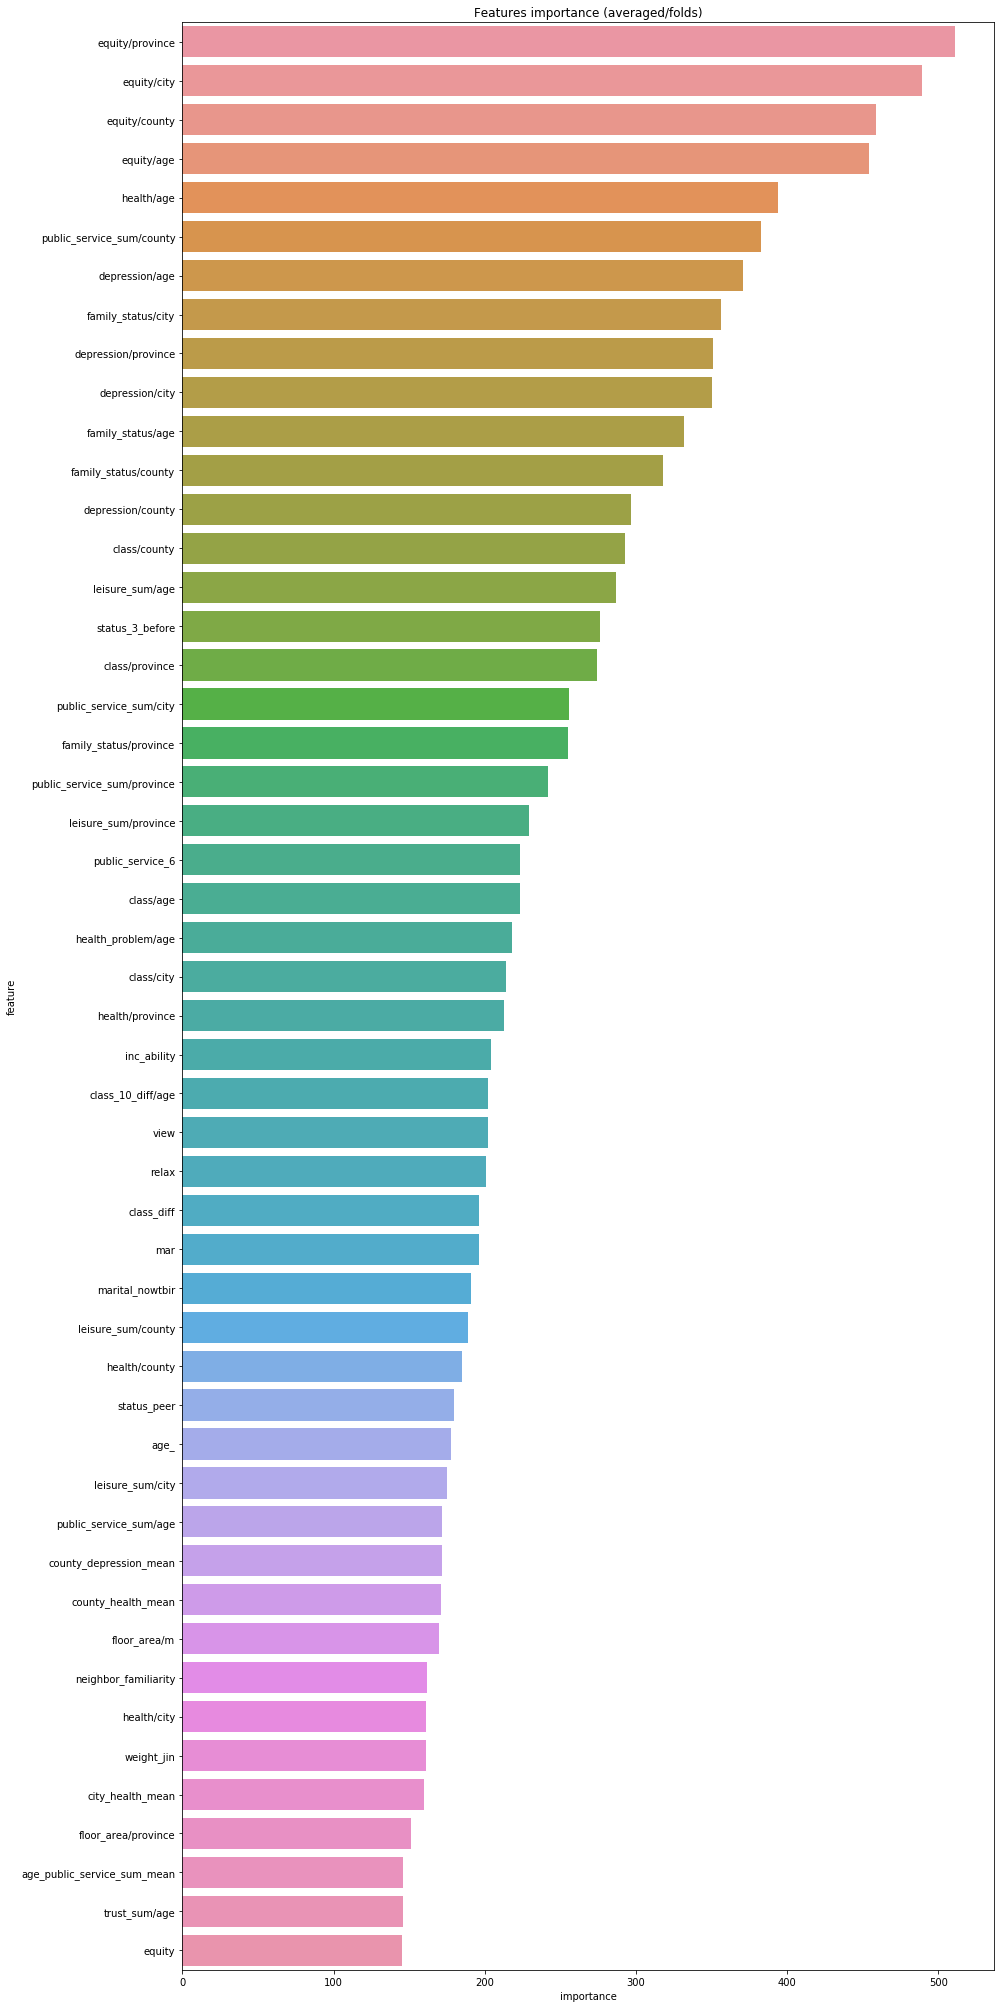

In [35]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

pd.set_option('max_colwidth',100)
df = pd.DataFrame(data[use_feature].columns.tolist(), columns=['feature'])
df['importance']=list(lgb_263.feature_importance())
df = df.sort_values(by='importance',ascending=False)
plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="feature", data=df.head(50))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()

### XGBoot

In [36]:
xgb_263_params = {'eta': 0.02,  
              'max_depth': 6,  
              'min_child_weight':3,
              'gamma':0,
              'subsample': 0.7,  
              'colsample_bytree': 0.3, 
              'lambda':2,
              'objective': 'reg:linear', 
              'eval_metric': 'rmse', 
              'silent': True, 
              'nthread': -1}


folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=2019)
oof_xgb_263 = np.zeros(len(X_train_263))
predictions_xgb_263 = np.zeros(len(X_test_263))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_263, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = xgb.DMatrix(X_train_263[trn_idx], y_train[trn_idx])
    val_data = xgb.DMatrix(X_train_263[val_idx], y_train[val_idx])

    watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
    xgb_263 = xgb.train(dtrain=trn_data, num_boost_round=3000, evals=watchlist, early_stopping_rounds=600, verbose_eval=500, params=xgb_263_params)
    oof_xgb_263[val_idx] = xgb_263.predict(xgb.DMatrix(X_train_263[val_idx]), ntree_limit=xgb_263.best_ntree_limit)
    predictions_xgb_263 += xgb_263.predict(xgb.DMatrix(X_test_263), ntree_limit=xgb_263.best_ntree_limit) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_xgb_263, target)))

fold n°1
[01:11:31] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[01:11:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:3.40000	valid_data-rmse:3.40006
[500]	train-rmse:0.40641	valid_data-rmse:0.68302
[1000]	train-rmse:0.27408	valid_data-rmse:0.68254
[1350]	train-rmse:0.20713	valid_data-rmse:0.68486
fold n°2
[01:12:13] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[01:12:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not 

### Random Forest

In [37]:
folds = KFold(n_splits=5, shuffle=True, random_state=2019)
oof_rfr_263 = np.zeros(len(X_train_263))
predictions_rfr_263 = np.zeros(len(X_test_263))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_263, y_train)):
    print("fold n°{}".format(fold_+1))
    tr_x = X_train_263[trn_idx]
    tr_y = y_train[trn_idx]
    rfr_263 = rfr(n_estimators=1600,max_depth=9, min_samples_leaf=9, min_weight_fraction_leaf=0.0,
            max_features=0.25,verbose=1,n_jobs=-1) 
    #verbose = 0 
#verbose = 1 
#verbose = 2 
    rfr_263.fit(tr_x,tr_y)
    oof_rfr_263[val_idx] = rfr_263.predict(X_train_263[val_idx])
    
    predictions_rfr_263 += rfr_263.predict(X_test_263) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_rfr_263, target)))

fold n°1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:   45.8s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:   58.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1600 out of 1600 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent worker

fold n°2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:   56.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1600 out of 1600 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent worker

fold n°3


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:   57.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1600 out of 1600 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent worker

fold n°4


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:   56.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 1600 out of 1600 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent worker

fold n°5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:   57.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 1600 out of 1600 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent worker

CV score: 0.47780150


[Parallel(n_jobs=4)]: Done 1600 out of 1600 | elapsed:    0.8s finished


### GradientBoostingRegressor

In [38]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=2018)
oof_gbr_263 = np.zeros(train_shape)
predictions_gbr_263 = np.zeros(len(X_test_263))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_263, y_train)):
    print("fold n°{}".format(fold_+1))
    tr_x = X_train_263[trn_idx]
    tr_y = y_train[trn_idx]
    gbr_263 = gbr(n_estimators=400, learning_rate=0.01,subsample=0.65,max_depth=7, min_samples_leaf=20,
            max_features=0.22,verbose=1)
    gbr_263.fit(tr_x,tr_y)
    oof_gbr_263[val_idx] = gbr_263.predict(X_train_263[val_idx])
    
    predictions_gbr_263 += gbr_263.predict(X_test_263) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_gbr_263, target)))

fold n°1
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.6643           0.0036           29.56s
         2           0.6718           0.0028           28.87s
         3           0.6466           0.0031           28.55s
         4           0.6430           0.0033           31.76s
         5           0.6443           0.0031           30.94s
         6           0.6405           0.0032           32.23s
         7           0.6396           0.0030           33.47s
         8           0.6301           0.0031           33.23s
         9           0.6226           0.0028           34.87s
        10           0.6266           0.0028           34.18s
        20           0.5830           0.0023           30.77s
        30           0.5908           0.0017           28.88s
        40           0.5286           0.0017           27.77s
        50           0.5056           0.0014           26.84s
        60           0.4886           0.0012           25.90

### ExtraTreesRegressor 

In [39]:
folds = KFold(n_splits=5, shuffle=True, random_state=13)
oof_etr_263 = np.zeros(train_shape)
predictions_etr_263 = np.zeros(len(X_test_263))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_263, y_train)):
    print("fold n°{}".format(fold_+1))
    tr_x = X_train_263[trn_idx]
    tr_y = y_train[trn_idx]
    etr_263 = etr(n_estimators=1000,max_depth=8, min_samples_leaf=12, min_weight_fraction_leaf=0.0,
            max_features=0.4,verbose=1,n_jobs=-1)
    etr_263.fit(tr_x,tr_y)
    oof_etr_263[val_idx] = etr_263.predict(X_train_263[val_idx])
    
    predictions_etr_263 += etr_263.predict(X_test_263) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_etr_263, target)))

fold n°1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   28.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s


fold n°2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   28.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s


fold n°3


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   29.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s


fold n°4


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   29.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s


fold n°5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   29.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s


CV score: 0.48560807


[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.3s finished


## Modeling & Feature Engineering - 49 features

### Light GBM

In [19]:
lgb_49_param = {
'num_leaves': 9,
'min_data_in_leaf': 23,
'objective':'regression',
'max_depth': -1,
'learning_rate': 0.002,
"boosting": "gbdt",
"feature_fraction": 0.45, 
"bagging_freq": 1,
"bagging_fraction": 0.65, 
"bagging_seed": 15,
"metric": 'mse',
"lambda_l2": 0.2, 
"verbosity": -1} 
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=9)   
oof_lgb_49 = np.zeros(len(X_train_49))
predictions_lgb_49 = np.zeros(len(X_test_49))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_49, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = lgb.Dataset(X_train_49[trn_idx], y_train[trn_idx])
    val_data = lgb.Dataset(X_train_49[val_idx], y_train[val_idx])

    num_round = 12000
    lgb_49 = lgb.train(lgb_49_param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 1000)
    oof_lgb_49[val_idx] = lgb_49.predict(X_train_49[val_idx], num_iteration=lgb_49.best_iteration)
    predictions_lgb_49 += lgb_49.predict(X_test_49, num_iteration=lgb_49.best_iteration) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_lgb_49, target)))

fold n°1
Training until validation scores don't improve for 1000 rounds
[1000]	training's l2: 0.470708	valid_1's l2: 0.49533
[2000]	training's l2: 0.430792	valid_1's l2: 0.475723
[3000]	training's l2: 0.408352	valid_1's l2: 0.470283
[4000]	training's l2: 0.390566	valid_1's l2: 0.467745
[5000]	training's l2: 0.375195	valid_1's l2: 0.466929
[6000]	training's l2: 0.36138	valid_1's l2: 0.466331
[7000]	training's l2: 0.348785	valid_1's l2: 0.466362
Early stopping, best iteration is:
[6501]	training's l2: 0.354929	valid_1's l2: 0.466144
fold n°2
Training until validation scores don't improve for 1000 rounds
[1000]	training's l2: 0.470545	valid_1's l2: 0.494825
[2000]	training's l2: 0.429727	valid_1's l2: 0.475862
[3000]	training's l2: 0.40708	valid_1's l2: 0.471551
[4000]	training's l2: 0.389121	valid_1's l2: 0.469654
[5000]	training's l2: 0.373686	valid_1's l2: 0.46918
[6000]	training's l2: 0.359722	valid_1's l2: 0.468886
[7000]	training's l2: 0.346965	valid_1's l2: 0.469111
Early stopping,

### XGBoost

In [20]:

xgb_49_params = {'eta': 0.02, 
              'max_depth': 5, 
              'min_child_weight':3,
              'gamma':0,
              'subsample': 0.7, 
              'colsample_bytree': 0.35, 
              'lambda':2,
              'objective': 'reg:linear', 
              'eval_metric': 'rmse', 
              'silent': True, 
              'nthread': -1}


folds = KFold(n_splits=5, shuffle=True, random_state=2019)
oof_xgb_49 = np.zeros(len(X_train_49))
predictions_xgb_49 = np.zeros(len(X_test_49))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_49, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = xgb.DMatrix(X_train_49[trn_idx], y_train[trn_idx])
    val_data = xgb.DMatrix(X_train_49[val_idx], y_train[val_idx])

    watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
    xgb_49 = xgb.train(dtrain=trn_data, num_boost_round=3000, evals=watchlist, early_stopping_rounds=600, verbose_eval=500, params=xgb_49_params)
    oof_xgb_49[val_idx] = xgb_49.predict(xgb.DMatrix(X_train_49[val_idx]), ntree_limit=xgb_49.best_ntree_limit)
    predictions_xgb_49 += xgb_49.predict(xgb.DMatrix(X_test_49), ntree_limit=xgb_49.best_ntree_limit) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_xgb_49, target)))

fold n°1
[00:50:53] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:50:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:3.40427	valid_data-rmse:3.38313
[500]	train-rmse:0.52689	valid_data-rmse:0.72122
[1000]	train-rmse:0.43485	valid_data-rmse:0.72264
[1163]	train-rmse:0.40941	valid_data-rmse:0.72325
fold n°2
[00:51:06] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:51:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not 

### GradientBoostingRegressor

In [21]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=2018)
oof_gbr_49 = np.zeros(train_shape)
predictions_gbr_49 = np.zeros(len(X_test_49))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_49, y_train)):
    print("fold n°{}".format(fold_+1))
    tr_x = X_train_49[trn_idx]
    tr_y = y_train[trn_idx]
    gbr_49 = gbr(n_estimators=600, learning_rate=0.01,subsample=0.65,max_depth=6, min_samples_leaf=20,
            max_features=0.35,verbose=1)
    gbr_49.fit(tr_x,tr_y)
    oof_gbr_49[val_idx] = gbr_49.predict(X_train_49[val_idx])
    
    predictions_gbr_49 += gbr_49.predict(X_test_49) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_gbr_49, target)))

fold n°1
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.6589           0.0033           18.70s
         2           0.6727           0.0033           18.76s
         3           0.6633           0.0031           20.59s
         4           0.6521           0.0031           20.65s
         5           0.6546           0.0029           19.42s
         6           0.6338           0.0032           18.58s
         7           0.6464           0.0028           19.06s
         8           0.6280           0.0030           20.19s
         9           0.6492           0.0029           20.58s
        10           0.6203           0.0029           19.85s
        20           0.5951           0.0024           17.50s
        30           0.5657           0.0022           22.89s
        40           0.5556           0.0016           21.81s
        50           0.5416           0.0012           20.54s
        60           0.5237           0.0011           20.40

In [22]:
train_stack3 = np.vstack([oof_lgb_49,oof_xgb_49,oof_gbr_49]).transpose()
test_stack3 = np.vstack([predictions_lgb_49, predictions_xgb_49,predictions_gbr_49]).transpose()
#
folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=7)
oof_stack3 = np.zeros(train_stack3.shape[0])
predictions_lr3 = np.zeros(test_stack3.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack3,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack3[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack3[val_idx], target.iloc[val_idx].values
        #Kernel Ridge Regression
    lr3 = kr()
    lr3.fit(trn_data, trn_y)
    
    oof_stack3[val_idx] = lr3.predict(val_data)
    predictions_lr3 += lr3.predict(test_stack3) / 10
    
mean_squared_error(target.values, oof_stack3) 

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9


0.4670808903788372

KernelRidge

In [28]:
folds = KFold(n_splits=5, shuffle=True, random_state=13)
oof_kr_49 = np.zeros(train_shape)
predictions_kr_49 = np.zeros(len(X_test_49))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_49, y_train)):
    print("fold n°{}".format(fold_+1))
    tr_x = X_train_49[trn_idx]
    tr_y = y_train[trn_idx]
    kr_49 = kr()
    kr_49.fit(tr_x,tr_y)
    oof_kr_49[val_idx] = kr_49.predict(X_train_49[val_idx])
    
    predictions_kr_49 += kr_49.predict(X_test_49) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_kr_49, target)))

fold n°1
fold n°2
fold n°3
fold n°4
fold n°5
CV score: 0.50338056


Ridge

In [29]:
folds = KFold(n_splits=5, shuffle=True, random_state=13)
oof_ridge_49 = np.zeros(train_shape)
predictions_ridge_49 = np.zeros(len(X_test_49))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_49, y_train)):
    print("fold n°{}".format(fold_+1))
    tr_x = X_train_49[trn_idx]
    tr_y = y_train[trn_idx]
    ridge_49 = Ridge(alpha=6)
    ridge_49.fit(tr_x,tr_y)
    oof_ridge_49[val_idx] = ridge_49.predict(X_train_49[val_idx])
    
    predictions_ridge_49 += ridge_49.predict(X_test_49) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_ridge_49, target)))

fold n°1
fold n°2
fold n°3
fold n°4
fold n°5
CV score: 0.49542586


BayesianRidge

In [30]:
folds = KFold(n_splits=5, shuffle=True, random_state=13)
oof_br_49 = np.zeros(train_shape)
predictions_br_49 = np.zeros(len(X_test_49))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_49, y_train)):
    print("fold n°{}".format(fold_+1))
    tr_x = X_train_49[trn_idx]
    tr_y = y_train[trn_idx]
    br_49 = br()
    br_49.fit(tr_x,tr_y)
    oof_br_49[val_idx] = br_49.predict(X_train_49[val_idx])
    
    predictions_br_49 += br_49.predict(X_test_49) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_br_49, target)))

fold n°1
fold n°2
fold n°3
fold n°4
fold n°5
CV score: 0.49625397


ElasticNet

In [31]:
folds = KFold(n_splits=5, shuffle=True, random_state=13)
oof_en_49 = np.zeros(train_shape)
predictions_en_49 = np.zeros(len(X_test_49))
#
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_49, y_train)):
    print("fold n°{}".format(fold_+1))
    tr_x = X_train_49[trn_idx]
    tr_y = y_train[trn_idx]
    en_49 = en(alpha=1.0,l1_ratio=0.05)
    en_49.fit(tr_x,tr_y)
    oof_en_49[val_idx] = en_49.predict(X_train_49[val_idx])
    
    predictions_en_49 += en_49.predict(X_test_49) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_en_49, target)))

fold n°1
fold n°2
fold n°3
fold n°4
fold n°5
CV score: 0.53860666


In [41]:
train_stack2 = np.vstack([oof_lgb_263,oof_xgb_263,oof_gbr_263,oof_rfr_263,oof_etr_263]).transpose()

test_stack2 = np.vstack([predictions_lgb_263, predictions_xgb_263,predictions_gbr_263,predictions_rfr_263,predictions_etr_263]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=7)
oof_stack2 = np.zeros(train_stack2.shape[0])
predictions_lr2 = np.zeros(test_stack2.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack2,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack2[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack2[val_idx], target.iloc[val_idx].values
    #Kernel Ridge Regression
    lr2 = kr()
    lr2.fit(trn_data, trn_y)
    
    oof_stack2[val_idx] = lr2.predict(val_data)
    predictions_lr2 += lr2.predict(test_stack2) / 10
    
mean_squared_error(target.values, oof_stack2) 

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9


0.4470559578172906

In [32]:
train_stack4 = np.vstack([oof_br_49,oof_kr_49,oof_en_49,oof_ridge_49]).transpose()
test_stack4 = np.vstack([predictions_br_49, predictions_kr_49,predictions_en_49,predictions_ridge_49]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=7)
oof_stack4 = np.zeros(train_stack4.shape[0])
predictions_lr4 = np.zeros(test_stack4.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack4,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack4[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack4[val_idx], target.iloc[val_idx].values
    #LinearRegression
    lr4 = lr()
    lr4.fit(trn_data, trn_y)
    
    oof_stack4[val_idx] = lr4.predict(val_data)
    predictions_lr4 += lr4.predict(test_stack1) / 10
    
mean_squared_error(target.values, oof_stack4) 


fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9


0.49585405823930767

### Modeling and Feature Engineering - 383 Features

Kernel Ridge Regression

In [23]:
folds = KFold(n_splits=5, shuffle=True, random_state=13)
oof_kr_383 = np.zeros(train_shape)
predictions_kr_383 = np.zeros(len(X_test_383))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_383, y_train)):
    print("fold n°{}".format(fold_+1))
    tr_x = X_train_383[trn_idx]
    tr_y = y_train[trn_idx]
    kr_383 = kr()
    kr_383.fit(tr_x,tr_y)
    oof_kr_383[val_idx] = kr_383.predict(X_train_383[val_idx])
    
    predictions_kr_383 += kr_383.predict(X_test_383) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_kr_383, target)))

fold n°1
fold n°2
fold n°3
fold n°4
fold n°5
CV score: 0.52041441


Ridge Regression

In [24]:
folds = KFold(n_splits=5, shuffle=True, random_state=13)
oof_ridge_383 = np.zeros(train_shape)
predictions_ridge_383 = np.zeros(len(X_test_383))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_383, y_train)):
    print("fold n°{}".format(fold_+1))
    tr_x = X_train_383[trn_idx]
    tr_y = y_train[trn_idx]
    ridge_383 = Ridge(alpha=1200)
    ridge_383.fit(tr_x,tr_y)
    oof_ridge_383[val_idx] = ridge_383.predict(X_train_383[val_idx])
    
    predictions_ridge_383 += ridge_383.predict(X_test_383) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_ridge_383, target)))

fold n°1
fold n°2
fold n°3
fold n°4
fold n°5
CV score: 0.48646216


ElasticNet

In [25]:
folds = KFold(n_splits=5, shuffle=True, random_state=13)
oof_en_383 = np.zeros(train_shape)
predictions_en_383 = np.zeros(len(X_test_383))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_383, y_train)):
    print("fold n°{}".format(fold_+1))
    tr_x = X_train_383[trn_idx]
    tr_y = y_train[trn_idx]
    en_383 = en(alpha=1.0,l1_ratio=0.06)
    en_383.fit(tr_x,tr_y)
    oof_en_383[val_idx] = en_383.predict(X_train_383[val_idx])
    
    predictions_en_383 += en_383.predict(X_test_383) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_en_383, target)))

fold n°1
fold n°2
fold n°3
fold n°4
fold n°5
CV score: 0.53288151


BayesianRidge 

In [26]:
folds = KFold(n_splits=5, shuffle=True, random_state=13)
oof_br_383 = np.zeros(train_shape)
predictions_br_383 = np.zeros(len(X_test_383))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_383, y_train)):
    print("fold n°{}".format(fold_+1))
    tr_x = X_train_383[trn_idx]
    tr_y = y_train[trn_idx]
    br_383 = br()
    br_383.fit(tr_x,tr_y)
    oof_br_383[val_idx] = br_383.predict(X_train_383[val_idx])
    
    predictions_br_383 += br_383.predict(X_test_383) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_br_383, target)))

fold n°1
fold n°2
fold n°3
fold n°4
fold n°5
CV score: 0.48669983


In [27]:
train_stack1 = np.vstack([oof_br_383,oof_kr_383,oof_en_383,oof_ridge_383]).transpose()
test_stack1 = np.vstack([predictions_br_383, predictions_kr_383,predictions_en_383,predictions_ridge_383]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=7)
oof_stack1 = np.zeros(train_stack1.shape[0])
predictions_lr1 = np.zeros(test_stack1.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack1,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack1[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack1[val_idx], target.iloc[val_idx].values
    # LinearRegression简单的线性回归
    lr1 = lr()
    lr1.fit(trn_data, trn_y)
    
    oof_stack1[val_idx] = lr1.predict(val_data)
    predictions_lr1 += lr1.predict(test_stack1) / 10
    
mean_squared_error(target.values, oof_stack1) 


fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9


0.4874379360552026

## Ensemble Model

In [42]:
train_stack5 = np.vstack([oof_stack1,oof_stack2,oof_stack3,oof_stack4]).transpose()
test_stack5 = np.vstack([predictions_lr1, predictions_lr2,predictions_lr3,predictions_lr4]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=7)
oof_stack5 = np.zeros(train_stack5.shape[0])
predictions_lr5= np.zeros(test_stack5.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack5,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack5[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack5[val_idx], target.iloc[val_idx].values
    #LinearRegression
    lr5 = lr()
    lr5.fit(trn_data, trn_y)
    
    oof_stack5[val_idx] = lr5.predict(val_data)
    predictions_lr5 += lr5.predict(test_stack5) / 10
    
mean_squared_error(target.values, oof_stack5) 


fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9


0.4470118822735938

### Submission

In [44]:
submit_example = pd.read_csv('/Users/Melodie/Downloads/2021Spring/Study/DataWhale/April_Ensembled_Learning/Notes_Ensemble_Learning/Data/case_1/submit_example.csv',sep=',',encoding='latin-1')

submit_example['happiness'] = predictions_lr5

submit_example.happiness.describe()

count    2968.000000
mean        3.879260
std         0.464408
min         1.696071
25%         3.661784
50%         3.954328
75%         4.185904
max         5.040234
Name: happiness, dtype: float64

In [45]:
submit_example.loc[submit_example['happiness']>4.96,'happiness']= 5
submit_example.loc[submit_example['happiness']<=1.04,'happiness']= 1
submit_example.loc[(submit_example['happiness']>1.96)&(submit_example['happiness']<2.04),'happiness']= 2

submit_example.to_csv("/Users/Melodie/Downloads/2021Spring/Study/DataWhale/April_Ensembled_Learning/Notes_Ensemble_Learning/Data/case_1/submision.csv",index=False)
submit_example.happiness.describe()

count    2968.000000
mean        3.879278
std         0.464340
min         1.696071
25%         3.661784
50%         3.954328
75%         4.185904
max         5.000000
Name: happiness, dtype: float64